# Solution

Let us Import Libraries , Dataset and define the Loss Function 

In [1]:
# Import Necessary Libraries
from __future__ import print_function

import sys
sys.path.append('/workspace/python/source_code')

import numpy as np 
import time
import importlib
import os
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.initializers import glorot_uniform
import tensorflow.keras.backend as K

# Custom Utlities
import model.flow_architecture as flow_architecture
import utils.data_utils as data_utils

import os
# reload(data_utils) # you need to execute this in case you modify the plotting scripts in data_utils

2.0.0


In [2]:
batch_size = 8
dataset_size = 2000   # Number of elements in the train.tfrecords
validation_size = 256 # Number of elements to use for validation

# derive some quantities
train_size = dataset_size - validation_size
train_batches = int(train_size / batch_size)
validation_batches= int(validation_size / batch_size)

test_size = 28
test_batches = int(test_size/batch_size)
print('Number of batches in train/validation/test dataset:', train_batches, '/', validation_batches, '/', test_batches)

def init_datasets():
    dataset = tf.data.TFRecordDataset('data/train.tfrecords')
    dataset = dataset.take(dataset_size)
    # Transform binary data into image arrays
    dataset = dataset.map(data_utils.parse_flow_data)
    
    training_dataset = dataset.skip(validation_size).shuffle(buffer_size=512)
    training_dataset = training_dataset.batch(batch_size, drop_remainder=True)

    validation_dataset = dataset.take(validation_size).batch(batch_size, drop_remainder=True)

    # Read test dataset
    test_dataset = tf.data.TFRecordDataset('data/test.tfrecords')
    test_dataset = test_dataset.map(data_utils.parse_flow_data) # Transform binary data into image arrays
    test_dataset = test_dataset.batch(batch_size, drop_remainder = True)
 
    return training_dataset, validation_dataset, test_dataset

training_dataset, validation_dataset, test_dataset = init_datasets()

Number of batches in train/validation/test dataset: 218 / 32 / 3


In [3]:
def loss_image(vflow_hat, vflow):
    ''' Defines the loss for the predicted flow.
    
    Arguments:
    vflow_hat -- predicted flow, shape (?, nh, nw, 2)
    vflow   -- target flow from the simulation, shape (?, nh, nw, 2)
    
    Returns: the L2 loss
    '''
    ### TODO define the squere error loss
    loss = tf.nn.l2_loss(vflow_hat - vflow)
    ###
                         
    # Add a scalar to tensorboard
    tf.summary.scalar('loss', loss)
    
    return loss

In [4]:
def concat_elu(x):
    """ like concatenated ReLU (http://arxiv.org/abs/1603.05201), but then with ELU """
    axis = len(x.get_shape())-1
    return elu(concatenate([x, -x], axis=axis))

In [5]:
# Helper Function to Set Non-linearity
def set_nonlinearity(name):
    if name == 'concat_elu':
        return concat_elu
    elif name == 'elu':
        return tf.nn.elu
    elif name == 'concat_relu':
        return tf.nn.crelu
    elif name == 'relu':
        return tf.nn.relu
    else:
        raise('nonlinearity ' + name + ' is not supported')

In [6]:
def res_block(x, a=None, filter_size=16, nonlinearity=concat_elu, rate=0, stride=1, gated=False, name="resnet"):
    """ Residual block of 3x3 convolutions """
    # Copy of our Input
    orig_x = x
    # Get Shape of Input data
    orig_x_int_shape = flow_architecture.int_shape(x)
    
    #### First Convolution Layer
    # If Input has one channel Data ( i.e., Input is our Input Image )
    if orig_x_int_shape[3] == 1:
        x_1 = flow_architecture.conv_layer(x, 3, stride, filter_size, name + '_conv_1')
    else:
        x_1 = flow_architecture.conv_layer(nonlinearity(x), 3, stride, filter_size, name + '_conv_1')
    
    # a is fed during the Up-sampling part of the Network ( Refer Upsampling block )
    if a is not None:
        shape_a = flow_architecture.int_shape(a)
        shape_x_1 = flow_architecture.int_shape(x_1)
        paddings = [[0,0],[0, shape_x_1[1]-shape_a[1]], [0, shape_x_1[2]-shape_a[2]], [0, 0]]
        a = tf.pad(a, paddings)
        x_1 = x_1 + flow_architecture.nin(nonlinearity(a), filter_size, name + '_nin')
    # Add Activation Function and Dropout
    x_1 = nonlinearity(x_1)
    x_1 = Dropout(rate=rate)(x_1)
    
    #### Second Convolution Layer 
    # Implemented Gated Residual Blocks 
    if not gated:
        x_2 = flow_architecture.conv_layer(x_1, 3, 1, filter_size, name + '_conv_2')
    else:
        x_2 = flow_architecture.conv_layer(x_1, 3, 1, filter_size*2, name + '_conv_2')
        x_2_1, x_2_2 = tf.split(axis=3,num_or_size_splits=2,value=x_2)
        x_2 = x_2_1 * tf.nn.sigmoid(x_2_2)
    
    # During Down-sampling Apply Pooling layer for the Input to Match the Outout
    if int(orig_x.get_shape()[2]) > int(x_2.get_shape()[2]):
        orig_x = tf.nn.avg_pool(orig_x, [1,2,2,1], [1,2,2,1], padding='SAME')

    # Pad Input Data
    out_filter = filter_size
    in_filter = int(orig_x.get_shape()[3])
    if out_filter != in_filter:
        orig_x = tf.pad( orig_x, [[0, 0], [0, 0], [0, 0], [(out_filter-in_filter), 0]])
    # Output Input Data + Output of Convolution Layer ( Why ? Because this is a Residual Block )
    return orig_x + x_2

In [7]:
def downsampling_res_blocks(x, nr_res_blocks, filter_size, nonlinearity, rate, gated,name_prefix, downsample):
    ''' An optional downsampling step followed by one (or more) residual blocks '''
    
    # Set Parameters and Call our Residual Block Function 
    if downsample:
        x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, rate=rate, stride=2,gated=gated, name=name_prefix + "downsample")
    for i in range(nr_res_blocks):
        x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, stride=1,rate=rate, gated=gated, name=name_prefix + str(i))      
    return x    


In [8]:
def upsumpling_res_blocks(x, nr_res_blocks, filter_size, nonlinearity, rate, gated, 
                        name_prefix, a):
    ''' Upsampling followed by a residual block '''
    # Set Parameters and Call our Residual Block Functions
    x = flow_architecture.transpose_conv_layer(x, 3, 2, filter_size, name_prefix)
    for i in range(nr_res_blocks):
        if i == 0:
            x = res_block(x, a, filter_size=filter_size, nonlinearity=nonlinearity, rate=rate, gated=gated, name=name_prefix + str(i))
        else:
            x = res_block(x, filter_size=filter_size, nonlinearity=nonlinearity, rate=rate, gated=gated, name=name_prefix + str(i))

    return x

In [9]:
def conv_res(inputs, nr_res_blocks=1, rate=1.0, nonlinearity_name='concat_elu', gated=True,depth=5):
    """Builds conv part of net.
    Args:
      inputs: input images
      rate: dropout layer
    """
    # Set Non-linearity
    nonlinearity = set_nonlinearity(nonlinearity_name)
    filter_size = 8
    # Store for Concatenation of the Downsampling output with the Upsampling blocks
    a = []
    
    # First Downsampling Residual Block to Convert Input Image from ( 128  ,256 ,1 ) to ( 128 , 256 , 8)
    
    x = downsampling_res_blocks(inputs, nr_res_blocks, filter_size, nonlinearity, rate, gated, "resnet_1_", False)
    
    # Loop Through Downsampling Blocks 
    for i in range(2,1+depth):
        a.append(x)
        filter_size = 2 * filter_size
        name_prefix = "resnet" + str(i) + "_"
        x = downsampling_res_blocks(x, nr_res_blocks, filter_size, nonlinearity, rate, gated, name_prefix, True)

    # Loop Through Up-sampling Blocks 
    for i in range(1,depth):
        filter_size = int(filter_size /2)
        name_prefix = "up_conv_" + str(i)
        x = upsumpling_res_blocks(x, nr_res_blocks, filter_size, nonlinearity, rate, gated, name_prefix, a[-i])
    
    # Last Convolution Layer with Activation 
    x = flow_architecture.conv_layer(x, 3, 1, 2, "last_conv")
    x = tf.nn.tanh(x)

    return x

In [10]:
def model(boundary, rate,gated=True,depth=5):
    return conv_res(boundary, nr_res_blocks=1, rate=rate, nonlinearity_name='concat_elu', gated=gated,depth=depth)

In [11]:
# Define Dropout Rate and Set Gated = False
rate = 0.4
gated = True
depth = 7
# Compile the Model
input = tf.keras.Input(shape=(128,256,1), name="boundary")
output = model(input,rate=rate,gated=gated,depth=depth)
unet = tf.keras.Model(inputs = input, outputs=output)
unet.compile(tf.keras.optimizers.Adam(0.001), loss=loss_image)
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
boundary (InputLayer)           [(None, 128, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 256, 8)  80          boundary[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_Neg (TensorFlowOpLa [(None, 128, 256, 8) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 256, 16) 0           conv2d[0][0]                     
                                                                 tf_op_layer_Neg[0][0]        

In [12]:
# Let's train our Model for 15 Epochs
results = unet.fit(training_dataset, epochs=15)

Epoch 1/15
218/218 [==============================] - 23s 106ms/step - loss: 2967.1688
Epoch 2/15
218/218 [==============================] - 16s 72ms/step - loss: 175.5182
Epoch 3/15
218/218 [==============================] - 17s 79ms/step - loss: 109.5243
Epoch 4/15
218/218 [==============================] - 27s 122ms/step - loss: 82.0275
Epoch 5/15
218/218 [==============================] - 45s 205ms/step - loss: 64.3336
Epoch 6/15
218/218 [==============================] - 40s 184ms/step - loss: 53.4843
Epoch 7/15
218/218 [==============================] - 48s 222ms/step - loss: 46.5193
Epoch 8/15
218/218 [==============================] - 48s 220ms/step - loss: 41.8727
Epoch 9/15
218/218 [==============================] - 46s 211ms/step - loss: 37.3337
Epoch 10/15
218/218 [==============================] - 44s 204ms/step - loss: 32.4180
Epoch 11/15
218/218 [==============================] - 54s 250ms/step - loss: 30.9813
Epoch 12/15
218/218 [==============================] - 49s 22

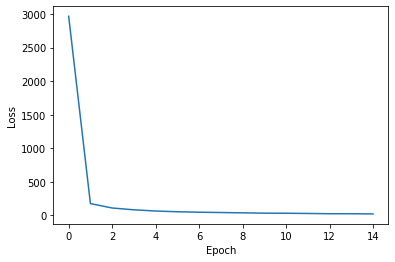

In [13]:
# Let us Plot the train History
data_utils.plot_keras_loss(results)

## Let's Test our Model

In [14]:
test_loss = unet.evaluate(test_dataset, steps=3)
print('The loss over the test dataset', test_loss)

3/3 [==============================] - 1s 415ms/step - loss: 5.7855
The loss over the test dataset 5.785533905029297


In [15]:
## Let's Test our Model

test_loss = unet.evaluate(test_dataset, steps=3)
print('The loss over the test dataset', test_loss)

3/3 [==============================] - 0s 40ms/step - loss: 5.7855
The loss over the test dataset 5.785534222920735


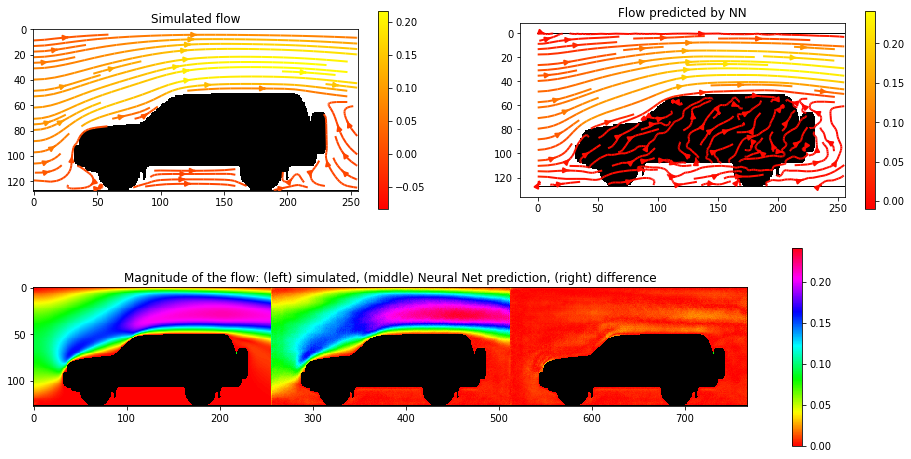

In [16]:
x, vxy = data_utils.load_test_data(1) # you can try different numbers between 1 and 28
vxy_hat = unet.predict(x)
data_utils.plot_test_result(x, vxy, vxy_hat)

## Licensing
This material is released by NVIDIA Corporation under the Creative Commons Attribution 4.0 International (CC BY 4.0)